In [56]:
import os
import csv
import json
from datetime import datetime
import pandas as pd

# ---------- SNMP část ----------
def snmp_get(oid):
    from pysnmp.hlapi import SnmpEngine, CommunityData, UdpTransportTarget, ContextData, ObjectType, ObjectIdentity, getCmd
    iterator = getCmd(
        SnmpEngine(),
        CommunityData('omegadejdar', mpModel=0),
        UdpTransportTarget(('192.168.11.100', 161), timeout=3, retries=2),
        ContextData(),
        ObjectType(ObjectIdentity(oid))
    )
    errorIndication, errorStatus, errorIndex, varBinds = next(iterator)
    if errorIndication or errorStatus:
        return None
    for varBind in varBinds:
        value = varBind[1]
        if isinstance(value, (int, float)):
            return int(value)
        elif hasattr(value, 'prettyPrint'):
            return value.prettyPrint()
        else:
            return str(value)

def snmp_ticks_to_hours(ticks):
    try:
        ms = int(float(ticks)) * 10
        return round(ms / 3_600_000, 2)
    except (TypeError, ValueError):
        return None

def safe_bytes_to_mb(current, previous=None, unit='binary', max_counter=2**32):
    try:
        current = int(current)
        if previous is not None:
            previous = int(previous)
            if current >= previous:
                delta = current - previous
            else:
                delta = (max_counter - previous) + current
        else:
            delta = current
        if unit == 'binary':
            return round(delta / (1024 * 1024), 2)
        elif unit == 'decimal':
            return round(delta / 1_000_000, 2)
        else:
            return None
    except (TypeError, ValueError):
        return None

# ---------- Cesty ----------
raw_log = 'traffic_log.csv'
dif_log = 'traffic_log_dif.csv'
state_file = 'traffic_state.json'

# ---------- OID definice ----------
oids = {
    'WAN_IN': '1.3.6.1.2.1.2.2.1.10.2',
    'WAN_OUT': '1.3.6.1.2.1.2.2.1.16.9', # změna "2" na "3" a "6" dne 20.10. 19:15 neúspěšná, změna na "9" 21:45
    'SYS_UPTIME': '1.3.6.1.2.1.1.3.0'
}

# ---------- Získání dat ----------
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
raw_isp_in = snmp_get(oids['WAN_IN'])
raw_lan_out = snmp_get(oids['WAN_OUT'])
raw_isp_uptime = snmp_get(oids['SYS_UPTIME'])
isp_uptime = snmp_ticks_to_hours(raw_isp_uptime)

# ---------- Načtení předchozího stavu ----------
if os.path.exists(state_file):
    with open(state_file, 'r') as f:
        state = json.load(f)
else:
    state = {}

# ---------- Výpočty ----------
delta_time_hr = None
delta_isp_in = None
delta_lan_out = None
restart = False

if 'timestamp' in state:
    prev_time = datetime.strptime(state['timestamp'], '%Y-%m-%d %H:%M:%S')
    delta_time_hr = round((datetime.now() - prev_time).total_seconds() / 3600, 2)

if 'uptime' in state and isp_uptime is not None:
    restart = isp_uptime < state['uptime']

if not restart:
    delta_isp_in = safe_bytes_to_mb(raw_isp_in, state.get('isp_in'))
    delta_lan_out = safe_bytes_to_mb(raw_lan_out, state.get('lan_out'))

# ---------- Zápis do traffic_log.csv ----------
write_header = not os.path.exists(raw_log) or os.path.getsize(raw_log) == 0
with open(raw_log, mode='a', newline='') as file:
    writer = csv.writer(file)
    if write_header:
        writer.writerow(['Time', 'ISP_IN_MB', 'LAN_OUT_MB', 'ISP_uptime'])
    writer.writerow([timestamp, safe_bytes_to_mb(raw_isp_in), safe_bytes_to_mb(raw_lan_out), isp_uptime])

# ---------- Zápis do traffic_log_dif.csv ----------
write_header_dif = not os.path.exists(dif_log) or os.path.getsize(dif_log) == 0
with open(dif_log, mode='a', newline='') as file:
    writer = csv.writer(file)
    if write_header_dif:
        writer.writerow(['Time', 'ISP_IN_MB', 'LAN_OUT_MB', 'ISP_uptime', 'Delta_ISP_IN_MB', 'Delta_LAN_OUT_MB', 'Delta_Time_hr', 'Restart'])
    writer.writerow([
        timestamp,
        safe_bytes_to_mb(raw_isp_in),
        safe_bytes_to_mb(raw_lan_out),
        isp_uptime,
        delta_isp_in,
        delta_lan_out,
        delta_time_hr,
        # restart
    ])

# ---------- Uložení aktuálního stavu ----------
with open(state_file, 'w') as f:
    json.dump({
        'timestamp': timestamp,
        'isp_in': raw_isp_in,
        'lan_out': raw_lan_out,
        'uptime': isp_uptime
    }, f)



In [63]:
import pandas as pd

df = pd.read_csv("traffic_log_dif.csv")

# Vytvoření nového sloupce s podílem ISP příchozího provozu na hodinu
df["ISP_IN_MB_per_hr"] = df["Delta_ISP_IN_MB"] / df["Delta_Time_hr"]
df["LAN_OUT_MB_per_hr"] = df["Delta_LAN_OUT_MB"] / df["Delta_Time_hr"]


# Volitelně: zaokrouhlení na 2 desetinná místa
df["ISP_IN_MB_per_hr"] = df["ISP_IN_MB_per_hr"].round(2)
df["LAN_OUT_MB_per_hr"] = df["LAN_OUT_MB_per_hr"].round(2)

# Seřazení podle času sestupně (nejnovější nahoře)
df_sorted = df.sort_values("Time", ascending=False)

# Zobrazení výsledku
df_sorted[["Time", "Delta_ISP_IN_MB", "Delta_LAN_OUT_MB", "Delta_Time_hr", "ISP_IN_MB_per_hr", "LAN_OUT_MB_per_hr"]]

,Time,Delta_ISP_IN_MB,Delta_LAN_OUT_MB,Delta_Time_hr,ISP_IN_MB_per_hr,LAN_OUT_MB_per_hr
57,2025-10-25 10:25:14,840.46,875.21,16.61,50.60,52.69
56,2025-10-24 17:48:45,254.96,270.43,10.94,23.31,24.72
55,2025-10-24 06:52:21,239.04,251.72,8.39,28.49,30.00
54,2025-10-23 22:29:14,234.56,252.47,6.56,35.76,38.49
53,2025-10-23 15:55:35,89.87,95.58,5.63,15.96,16.98
52,2025-10-23 10:17:53,102.45,105.62,3.31,30.95,31.91
51,2025-10-23 06:59:24,181.69,187.29,9.46,19.21,19.80
50,2025-10-22 21:31:49,438.34,459.55,14.63,29.96,31.41
49,2025-10-22 06:53:49,139.15,148.74,9.29,14.98,16.01
48,2025-10-21 21:36:15,276.91,287.73,5.93,46.70,48.52


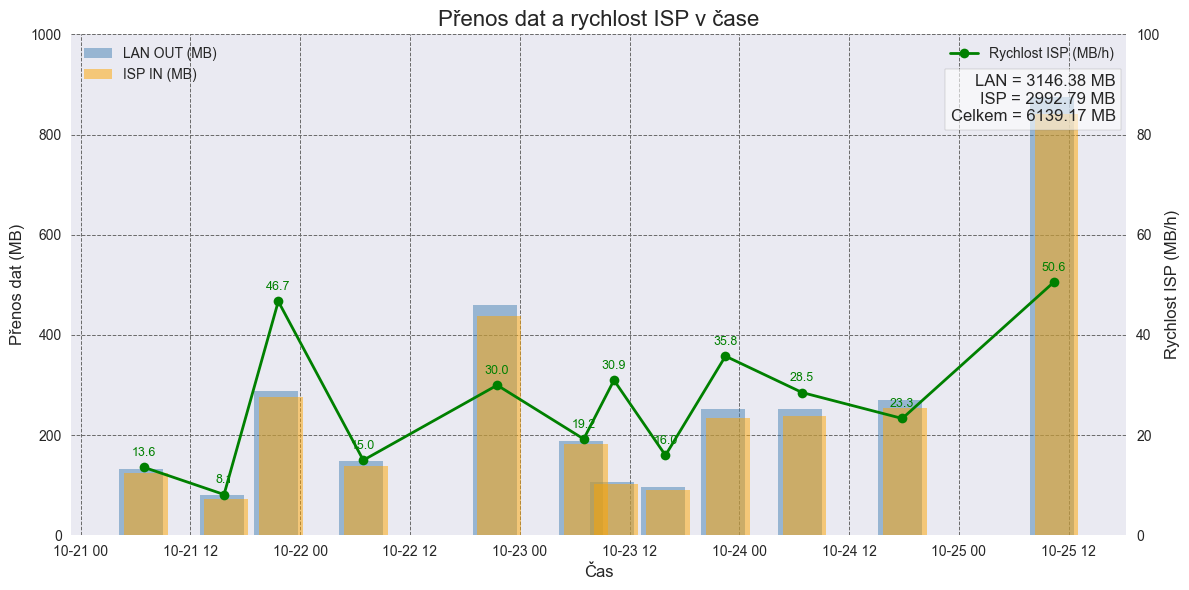

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Načtení dat ---
df = pd.read_csv('/Users/Marek/tableau_project/Rx_Tx_new/traffic_log_dif.csv')
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

# --- Filtrování od 21. října ---
df = df[df['Time'] >= '2025-10-21']

# --- Výpočty ---
df['ISP_Speed_MB_per_hr'] = (df['Delta_ISP_IN_MB'] / df['Delta_Time_hr']).round(2)
lan_sum = df["Delta_LAN_OUT_MB"].sum()
isp_sum = df["Delta_ISP_IN_MB"].sum()
total_sum = lan_sum + isp_sum

# --- Vykreslení ---
plt.style.use('seaborn-v0_8')
fig, ax1 = plt.subplots(figsize=(12, 6))

x = df['Time']
bar_width = 0.2
offset = pd.Timedelta(minutes=15) # sloupce vedle sebe

# Sloupcový graf na hlavní ose
ax1.bar(x - offset, df['Delta_LAN_OUT_MB'], width=bar_width, label='LAN OUT (MB)', color='steelblue', alpha=0.5)
ax1.bar(x + offset, df['Delta_ISP_IN_MB'], width=bar_width, label='ISP IN (MB)', color='orange', alpha=0.5)

ax1.set_ylabel('Přenos dat (MB)', fontsize=12)
ax1.legend(loc='upper left')

# Vedlejší osa pro rychlost
ax2 = ax1.twinx()
ax2.plot(x, df['ISP_Speed_MB_per_hr'], color='green', marker='o', linewidth=2, label='Rychlost ISP (MB/h)')
ax2.set_ylabel('Rychlost ISP (MB/h)', fontsize=12)
ax2.legend(loc='upper right')

# Doplnění hodnot nad markery
for i in range(len(df)):
    ax2.annotate(
        f"{df['ISP_Speed_MB_per_hr'].iloc[i]:.1f}",
        (df['Time'].iloc[i], df['ISP_Speed_MB_per_hr'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 8),  # posun nad marker
        ha='center',
        fontsize=9,
        color='green'
    )

# Popisky a souhrn
ax1.set_title('Přenos dat a rychlost ISP v čase', fontsize=16)
ax1.set_xlabel('Čas', fontsize=12)
plt.xticks(rotation=45)

summary = f"LAN = {lan_sum:.2f} MB\nISP = {isp_sum:.2f} MB\nCelkem = {total_sum:.2f} MB"
plt.text(0.99, 0.92, summary, transform=ax1.transAxes,
         fontsize=12, ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 100)
ax1.grid(True, color='dimgray', linestyle='--', linewidth=0.7)
ax2.grid(False)

# --- Uložení a zobrazení ---
output_path = '/Users/Marek/tableau_project/Rx_Tx_new/graf_spotreba_a_rychlost.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.tight_layout()
plt.savefig(output_path)
plt.show()
plt.close()